<a href="https://colab.research.google.com/github/tinayiluo0322/Computer-Engineering-Machine-Learning-and-Deep-Neural-Nets-Projects/blob/main/Pruning%20and%20Fixed-point%20Quantization/Sparse_optimization_of_linear_models_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Sparse optimization of linear models

### Luopeiwen Yi

By now you have seen multiple ways to induce a sparse solution in the optimization process. This problem will provide you some examples under linear regression setting so that you can compare the effectiveness of different methods. For this problem, consider the case where we are trying to find a sparse weight W that can minimize L = 􏰀i(XiW − yi)2. Specifically, we have Xi ∈ R1×5, W ∈ R5×1 and ||W||0 ≤ 2.

Consider the case where we have 3 data points: (X1 = [−2, 2, 1, −1, −1], y1 = 5); (X2 = [−2, 1, −2, 0, 1], y2 = 1); (X3 = [1, 0, −2, 2, −1], y3 = 1). For stability the objective L should be minimized through full-batch gradient descent, with initial weight W 0 set to [0; 0; 0; 0; 0] and use learning rate μ = 0.02 throughout the process. Please run gradient descent for 200 steps for all the following problems. For log(L) plot, please use matplotlib.pyplot.yscale(’log’)

### Gradient Descent without Sparsity Constraint

In Python, directly minimize the objective L without any sparsity-inducing regularization/constraint. Plot the value of log(L) vs. #steps throughout the training, and use another figure to plot how the value of each element in W is changing throughout the training. From your result, is W converging to an optimal solution? Is W converging to a sparse solution?

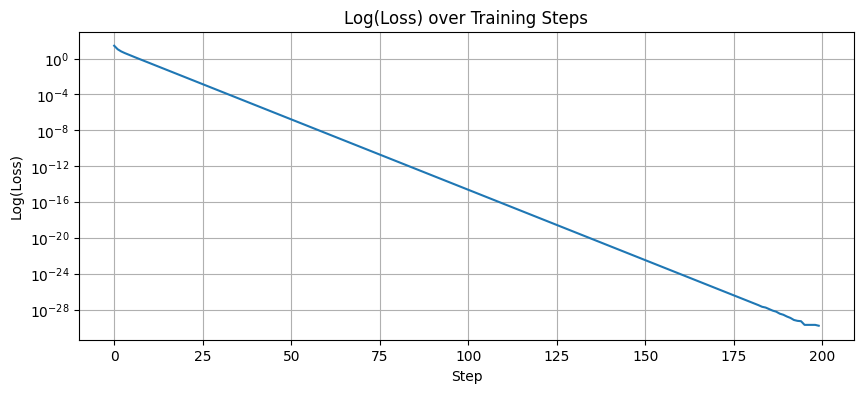

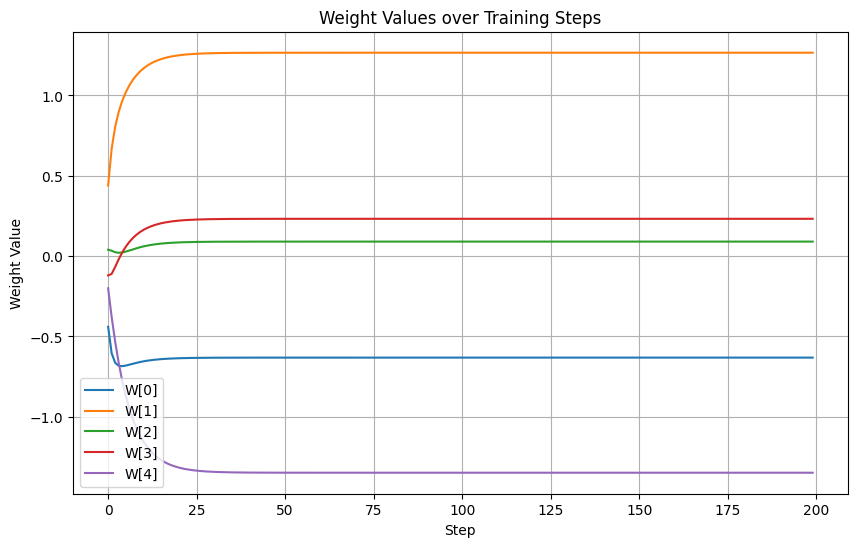

In [8]:
# Data
X = np.array([
    [-2, 2, 1, -1, -1],
    [-2, 1, -2, 0, 1],
    [ 1, 0, -2, 2, -1]
])  # shape (3, 5)

y = np.array([5, 1, 1]).reshape(-1, 1)  # shape (3, 1)

# Hyperparameters
mu = 0.02
steps = 200

# Initialize weight
W = np.zeros((5, 1))

# Track loss and weights
loss_list = []
W_history = []

for step in range(steps):
    # Compute prediction
    y_pred = X @ W

    # Compute loss
    loss = np.sum((y_pred - y) ** 2)
    loss_list.append(loss)

    # Compute gradient
    grad = 2 * X.T @ (y_pred - y)

    # Gradient descent step
    W = W - mu * grad
    W_history.append(W.flatten())  # store copy of current weights

W_history = np.array(W_history)  # shape (steps, 5)

# Plot log(L) vs. steps
plt.figure(figsize=(10, 4))
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Log(Loss)')
plt.title('Log(Loss) over Training Steps')
plt.grid(True)
plt.show()

# Plot W values over time
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(W_history[:, i], label=f'W[{i}]')
plt.xlabel('Step')
plt.ylabel('Weight Value')
plt.title('Weight Values over Training Steps')
plt.legend()
plt.grid(True)
plt.show()

1. According to the graphs, the loss flattens out and weights stabilizes, so W converges to an optimal solution.

2. According to the graphs, all the weights remain non-zero, so W does not converge to a sparse solution.

### Projected Gradient Descent with Sparse Constraint

Since we have the knowledge that the ground-truth weight should have ||W ||0 ≤ 2, we can apply projected gradient descent to enforce this sparse constraint. Redo the optimization process in (b), this time prune the elements in W after every gradient descent step to ensure ||Wl||0 ≤ 2. Plot the value of log(L) throughout the training, and use another figure to plot the value of each element in W in each step. From your result, is W converging to an optimal solution? Is W converging to a sparse solution?

This code implements projected gradient descent, where:

- After every gradient step, I prune
𝑊 to ensure sparsity

- This way enforces
∥
𝑊
∥
0
≤
2
during training

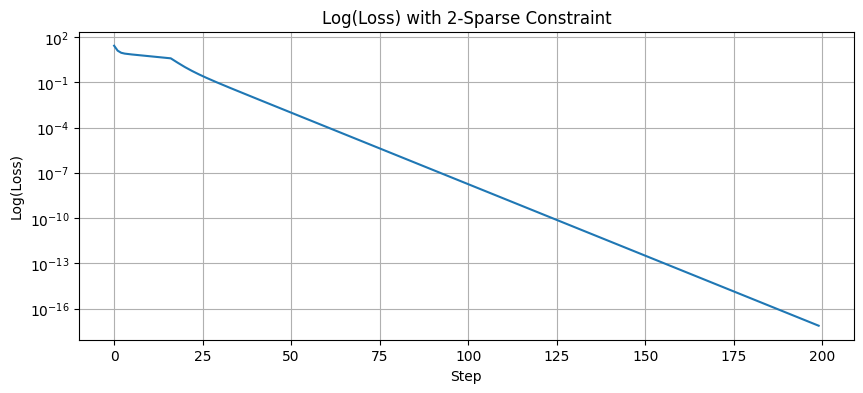

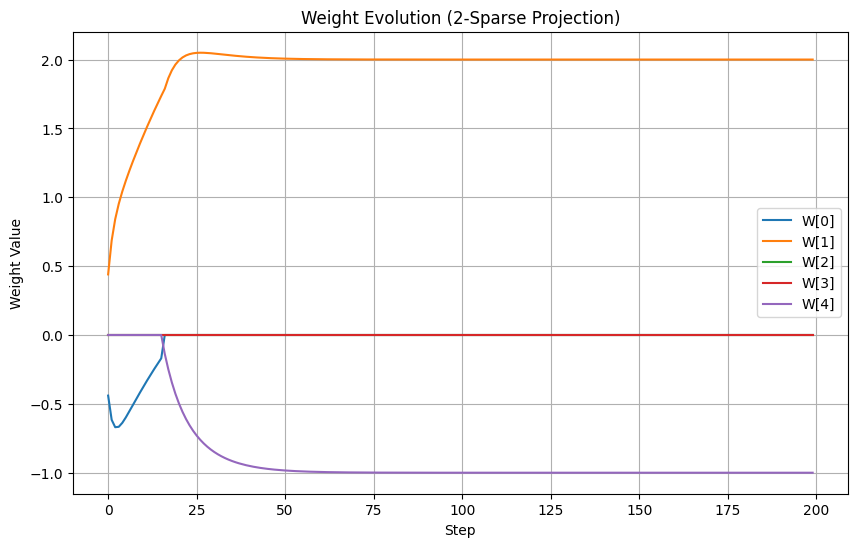

In [9]:
# Reset everything
X = np.array([
    [-2, 2, 1, -1, -1],
    [-2, 1, -2, 0, 1],
    [ 1, 0, -2, 2, -1]
])
y = np.array([5, 1, 1]).reshape(-1, 1)
mu = 0.02
steps = 200

W = np.zeros((5, 1))
loss_list = []
W_history = []

def project_to_k_sparse(W, k):
    # Flatten and get absolute values
    flat_W = W.flatten()
    # Indices of top-k absolute values
    topk_idx = np.argsort(np.abs(flat_W))[-k:]
    # Create new zeroed-out weight vector
    W_proj = np.zeros_like(flat_W)
    W_proj[topk_idx] = flat_W[topk_idx]
    return W_proj.reshape(W.shape)

for step in range(steps):
    # Prediction
    y_pred = X @ W
    loss = np.sum((y_pred - y) ** 2)
    loss_list.append(loss)

    # Gradient
    grad = 2 * X.T @ (y_pred - y)

    # Gradient descent step
    W = W - mu * grad

    # Project to 2-sparse vector
    W = project_to_k_sparse(W, k=2)

    # Track weights
    W_history.append(W.flatten())

W_history = np.array(W_history)

# Plot log(L)
plt.figure(figsize=(10, 4))
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Log(Loss)')
plt.title('Log(Loss) with 2-Sparse Constraint')
plt.grid(True)
plt.show()

# Plot W values over steps
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(W_history[:, i], label=f'W[{i}]')
plt.xlabel('Step')
plt.ylabel('Weight Value')
plt.title('Weight Evolution (2-Sparse Projection)')
plt.legend()
plt.grid(True)
plt.show()

1. According to the graphs, the loss consistently decreases over the training steps. While it's not completely flat by the end, the weights themselves stabilize, which suggests that
W is likely converging to an optimal solution under the sparsity constraint.

2. According to the graphs, we observe that only 2 of the 5 weights are non-zero, while the remaining weights are pruned to zero, suggesting W converges to a sparse solution.

### L1 Regularization

In this problem we apply l1 regularization to induce the sparse solution. The minimization objective therefore changes to L + λ||W ||1. Please use full-batch gradient descent to minimize this objective, with λ = {0.2, 0.5, 1.0, 2.0} respectively. For each case, plot the value of log(L) throughout the training, and use another figure to plot the value of each element in W in each step. From your result, comment on the convergence performance under different λ.

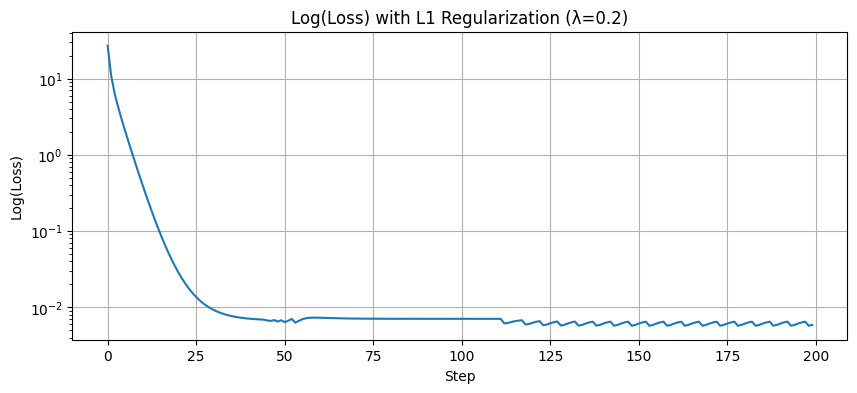

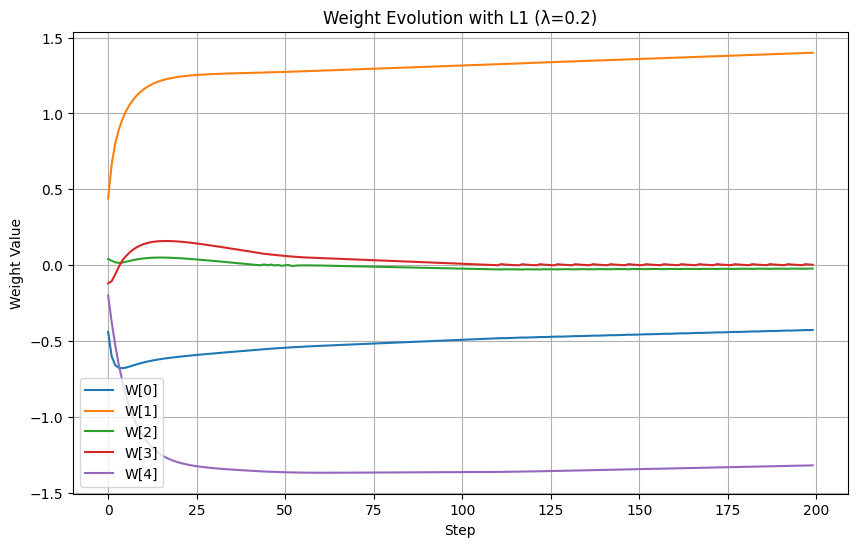

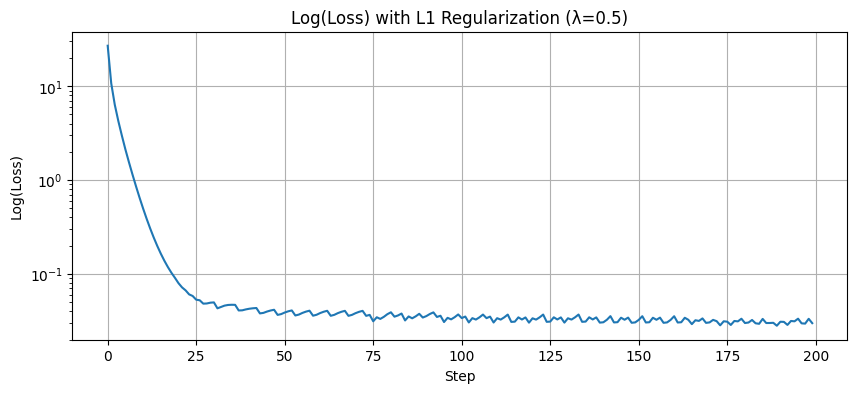

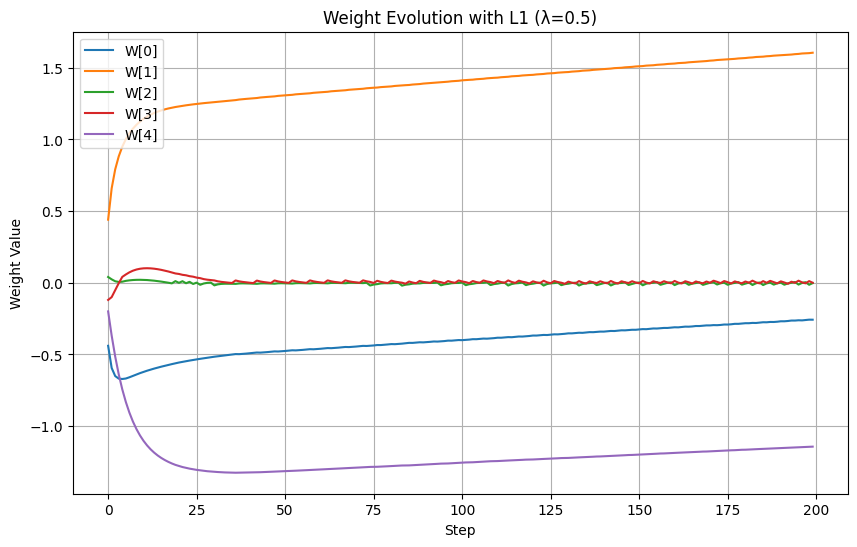

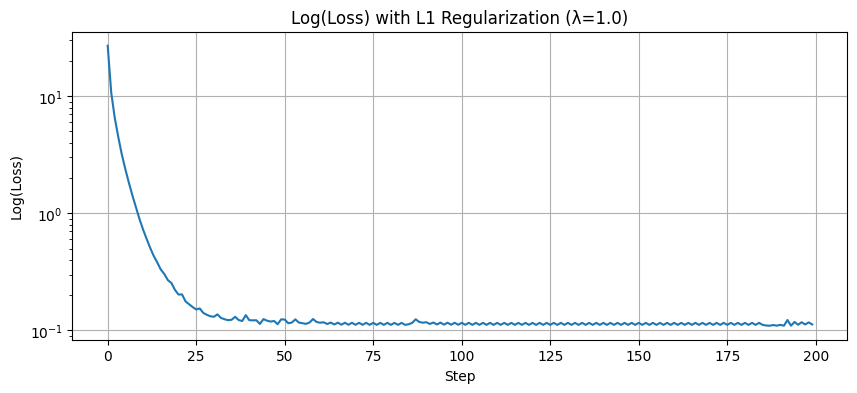

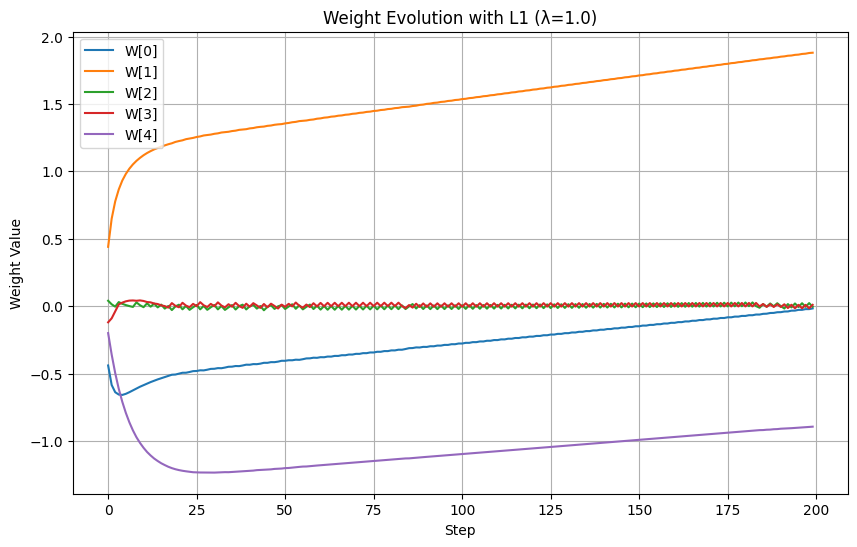

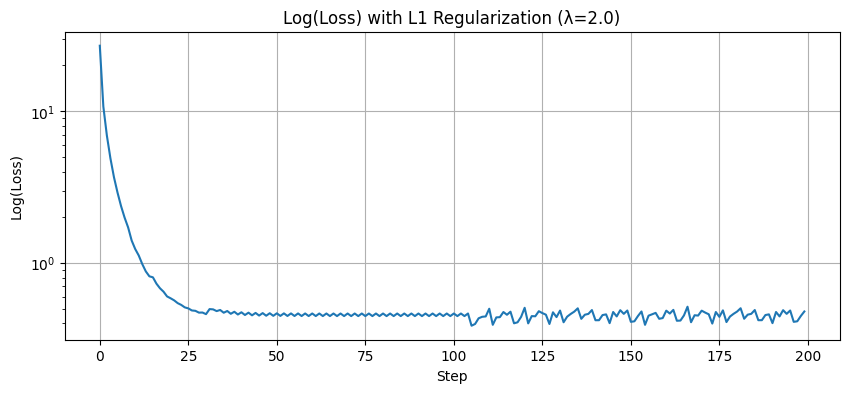

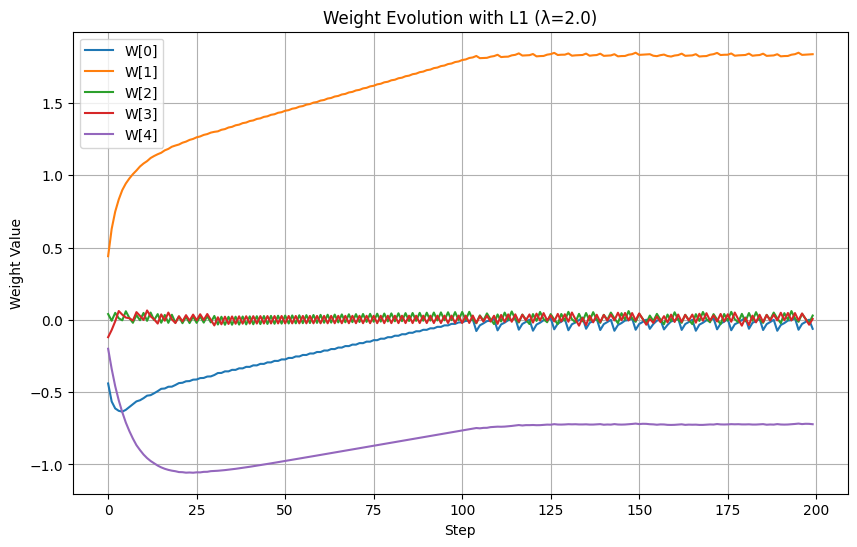

In [10]:
# Setup
X = np.array([
    [-2, 2, 1, -1, -1],
    [-2, 1, -2, 0, 1],
    [ 1, 0, -2, 2, -1]
])
y = np.array([5, 1, 1]).reshape(-1, 1)
mu = 0.02
steps = 200
lambdas = [0.2, 0.5, 1.0, 2.0]

for lam in lambdas:
    W = np.zeros((5, 1))
    loss_list = []
    W_history = []

    for step in range(steps):
        # Prediction
        y_pred = X @ W

        # Unregularized loss
        loss = np.sum((y_pred - y) ** 2)
        loss_list.append(loss)

        # Gradient of loss + L1
        grad = 2 * X.T @ (y_pred - y) + lam * np.sign(W)

        # Update step
        W = W - mu * grad
        W_history.append(W.flatten())

    W_history = np.array(W_history)

    # Plot log(L) vs steps
    plt.figure(figsize=(10, 4))
    plt.plot(loss_list)
    plt.yscale('log')
    plt.xlabel('Step')
    plt.ylabel('Log(Loss)')
    plt.title(f'Log(Loss) with L1 Regularization (λ={lam})')
    plt.grid(True)
    plt.show()

    # Plot weight trajectories
    plt.figure(figsize=(10, 6))
    for i in range(5):
        plt.plot(W_history[:, i], label=f'W[{i}]')
    plt.xlabel('Step')
    plt.ylabel('Weight Value')
    plt.title(f'Weight Evolution with L1 (λ={lam})')
    plt.legend()
    plt.grid(True)
    plt.show()


(1) For all values of
λ, the loss consistently decreases and nearly flattens out but has fluctuations. The weights tend to stabilize but some weights has fluctuations, indicating that
W likely converges to an optimal solution under each regularization strength but usually has some struggles with convergence.

(2) For smaller
λ values (e.g., 0.2), more weights remain non-zero, resulting in a less sparse solution. These cases tend to converge faster and achieve lower loss. In contrast, for larger
λ values (e.g., 2.0), more weights shrink toward zero, leading to a sparser solution, but convergence is slower and the final loss is higher due to stronger regularization.

### Proximal Gradient Update

Here we optimize the same objectiveas as above,this time using proximal gradient update. Recall that the proximal operator of the l1 regularizer is the soft thresholding function. Set the threshold in the soft thresholding function to {0.004, 0.01, 0.02, 0.04} respectively. Plot the value of log(L) throughout the training, and use another figure to plot the value of each element in W in each step. Compare the convergence performance with the results above. (Hint: Optimizing L + λ||W ||1 using gradient descent with learning rate μ should correspond to proximal gradient update with threshold μλ)

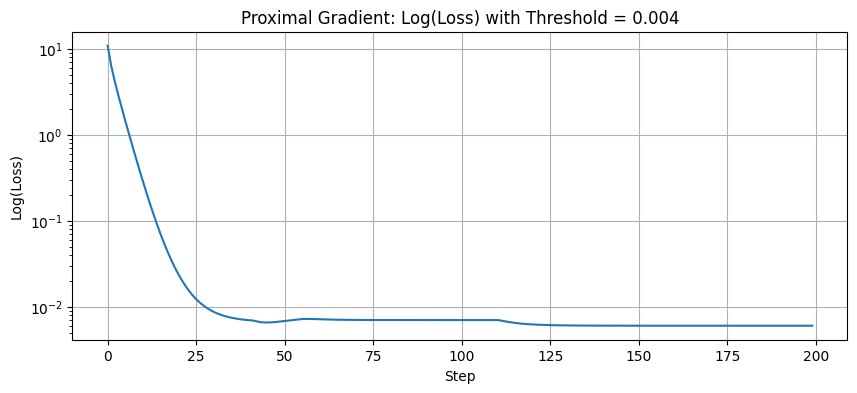

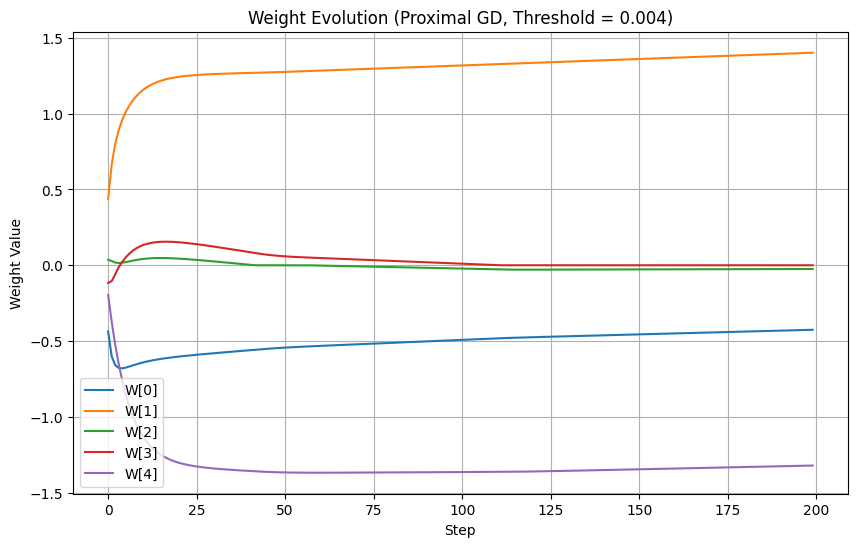

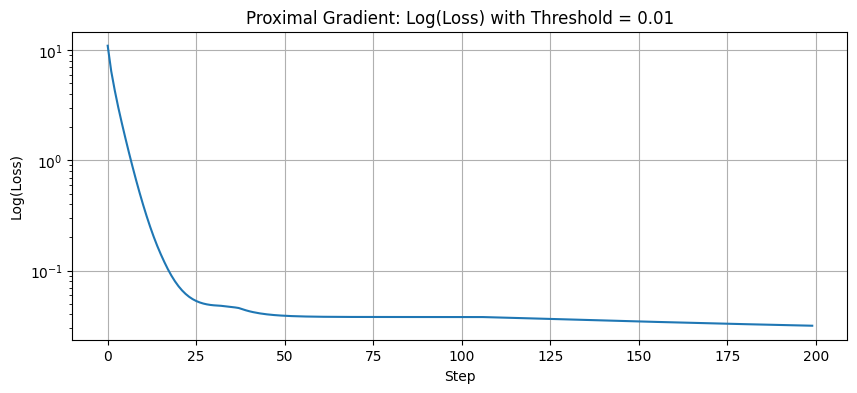

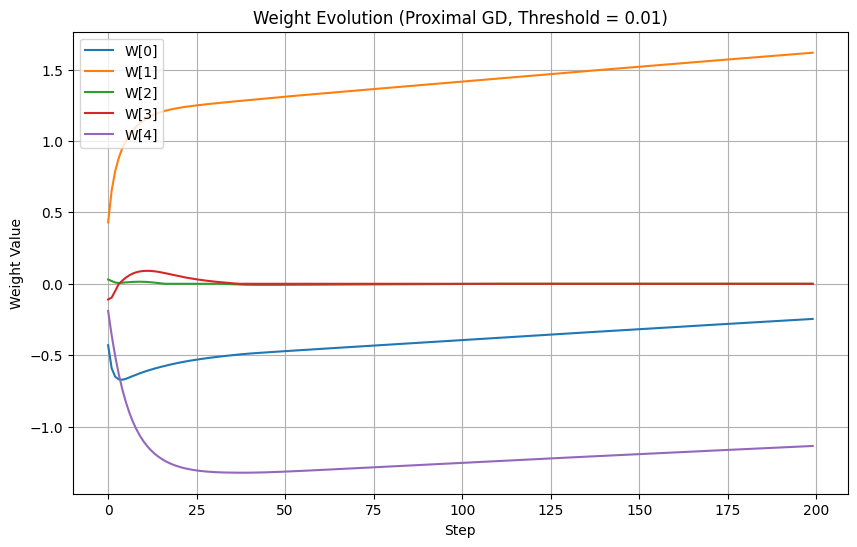

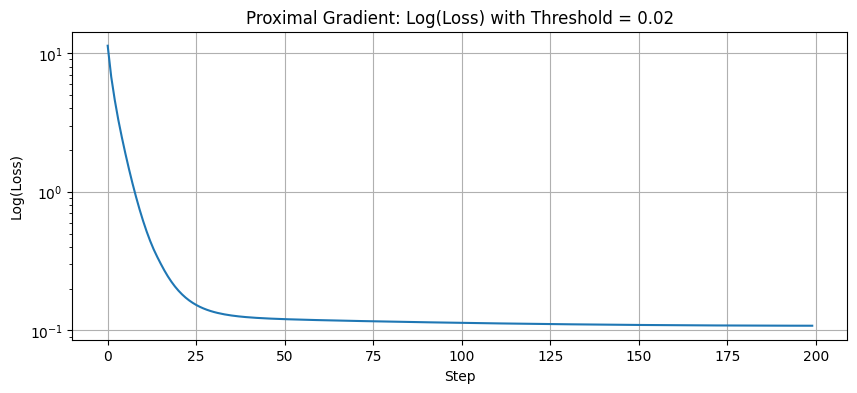

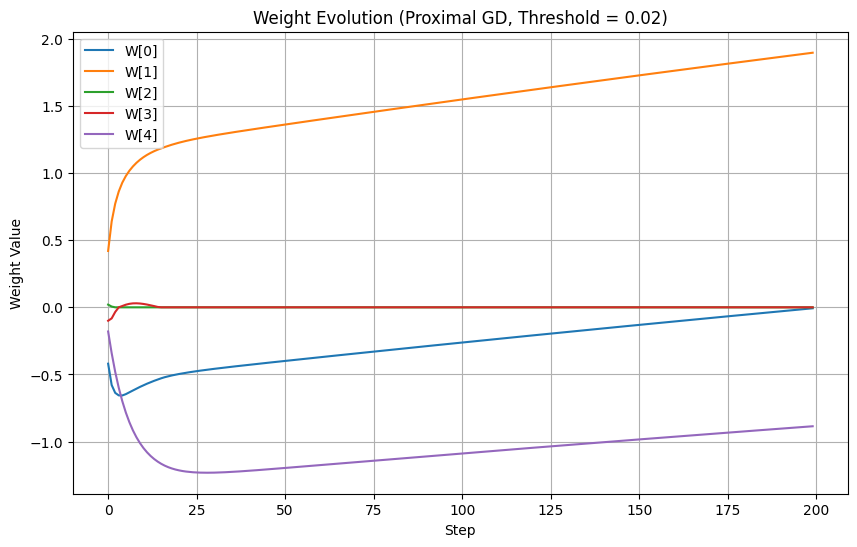

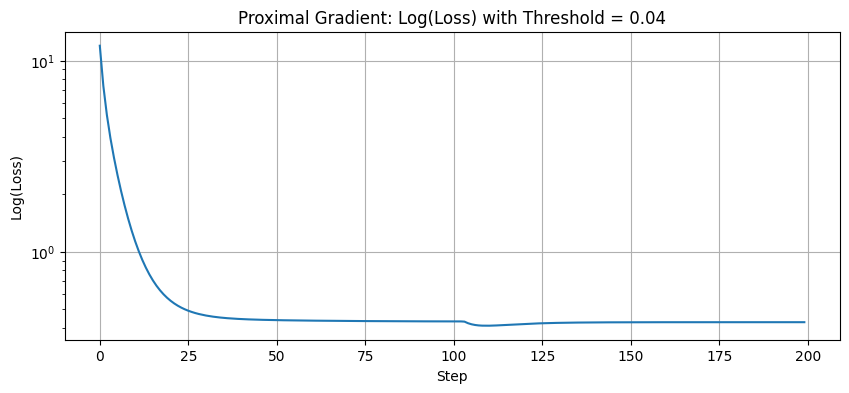

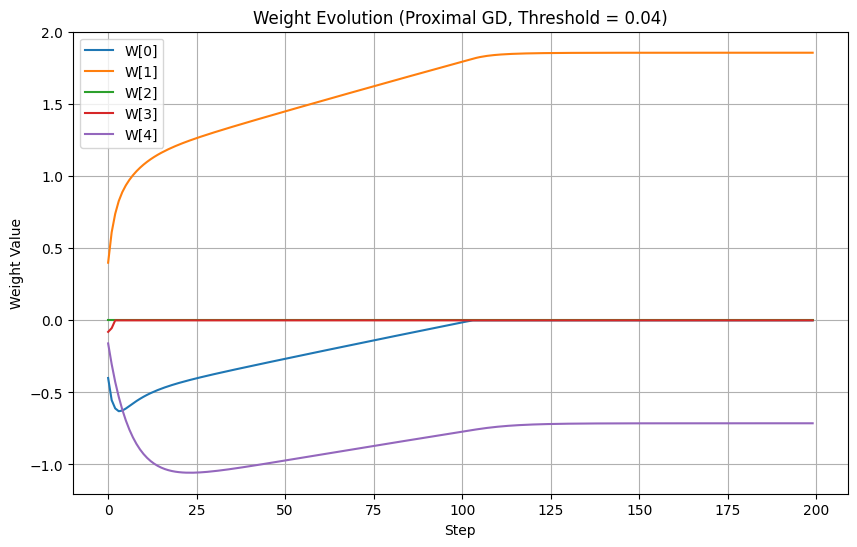

In [11]:
# Data
X = np.array([
    [-2, 2, 1, -1, -1],
    [-2, 1, -2, 0, 1],
    [ 1, 0, -2, 2, -1]
])
y = np.array([5, 1, 1]).reshape(-1, 1)
mu = 0.02
steps = 200

# Thresholds to test = mu * lambda
thresholds = [0.004, 0.01, 0.02, 0.04]

def soft_threshold(W, tau):
    return np.sign(W) * np.maximum(np.abs(W) - tau, 0.0)

for tau in thresholds:
    W = np.zeros((5, 1))
    loss_list = []
    W_history = []

    for step in range(steps):
        # Gradient of loss (no L1 included here!)
        grad = 2 * X.T @ (X @ W - y)

        # Gradient descent step
        W_temp = W - mu * grad

        # Apply soft thresholding
        W = soft_threshold(W_temp, tau)

        # Compute original loss (without L1)
        loss = np.sum((X @ W - y) ** 2)
        loss_list.append(loss)
        W_history.append(W.flatten())

    W_history = np.array(W_history)

    # Plot log(L)
    plt.figure(figsize=(10, 4))
    plt.plot(loss_list)
    plt.yscale('log')
    plt.xlabel('Step')
    plt.ylabel('Log(Loss)')
    plt.title(f'Proximal Gradient: Log(Loss) with Threshold = {tau}')
    plt.grid(True)
    plt.show()

    # Plot weight trajectories
    plt.figure(figsize=(10, 6))
    for i in range(5):
        plt.plot(W_history[:, i], label=f'W[{i}]')
    plt.xlabel('Step')
    plt.ylabel('Weight Value')
    plt.title(f'Weight Evolution (Proximal GD, Threshold = {tau})')
    plt.legend()
    plt.grid(True)
    plt.show()

(1) For all threshold values
τ, the loss consistently decreases and flattens out over time. The weights also stabilize, indicating that
W converges to an optimal solution under each regularization strength. Compared to standard L1 gradient descent, proximal gradient descent yields smoother and more stable convergence.

(2) For smaller thresholds (e.g., τ=0.004, corresponding to λ=0.2), more weights remain non-zero, resulting in a less sparse solution and faster convergence with lower final loss. In contrast, for larger thresholds (e.g.,
τ=0.04, corresponding to λ=2.0), more weights are driven toward zero, leading to a sparser solution. However, convergence tends to be slower, and the final loss is higher due to stronger regularization pressure.

### Trimmed L1 (Tl1) regularizer

Trimmed l1 (Tl1) regularizer is proposed to solve the “bias” problem of l1. For simplicity you may implement the T l1 regularizer as applying a l1 regularization with strength λ on the 3 elements of W with the smallest absolute value, with no penalty on other elements. Minimize L + λT l1 (W ) using proximal gradient update with λ = {1.0, 2.0, 5.0, 10.0} (correspond the soft thresholding threshold {0.02, 0.04, 0.1, 0.2}). Plot the value of log(L) throughout the training, and use another figure to plot the value of each element in W in each step. Comment on the convergence comparison of the Trimmed l1 and the l1. Also compare the behavior of the early steps (e.g. first 20) between the Trimmed l1 and the iterative pruning.

Only applying L1 penalty to the 3 smallest weights (by magnitude), leaving the top 2 largest ones untouched.

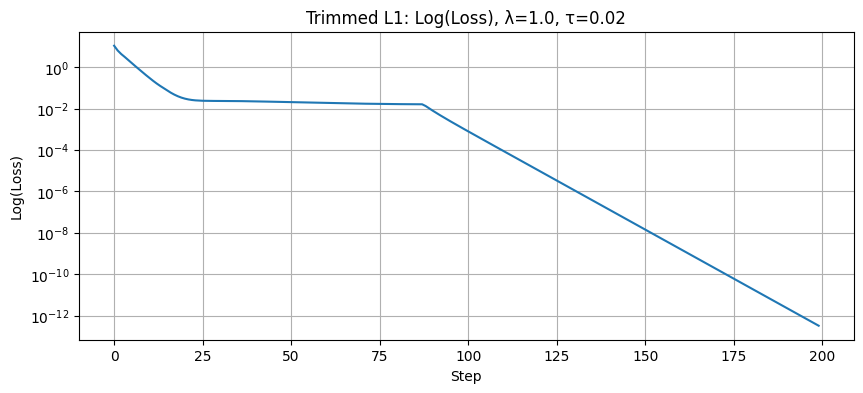

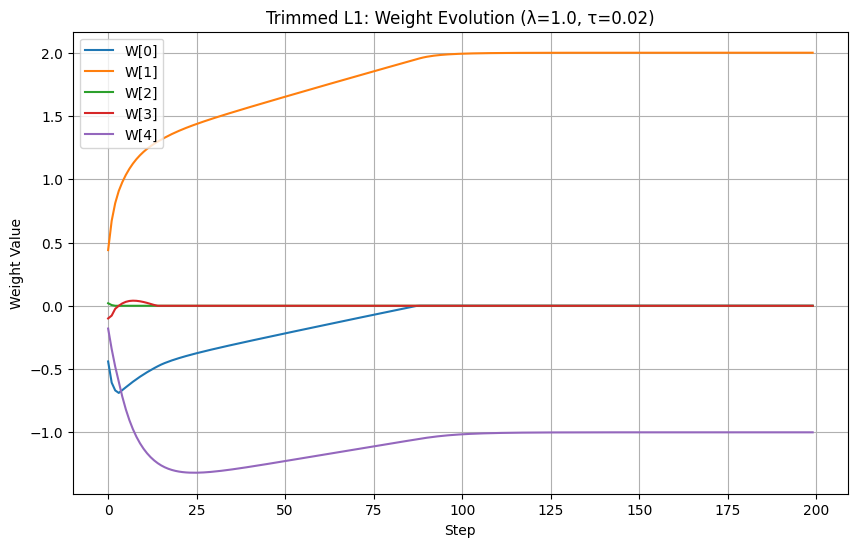

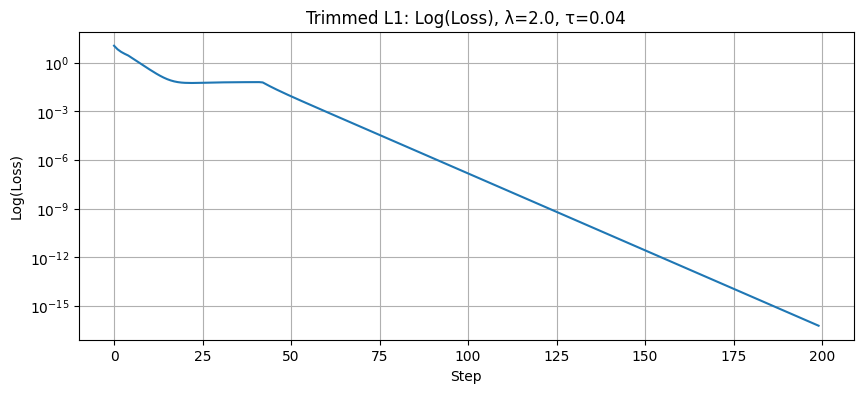

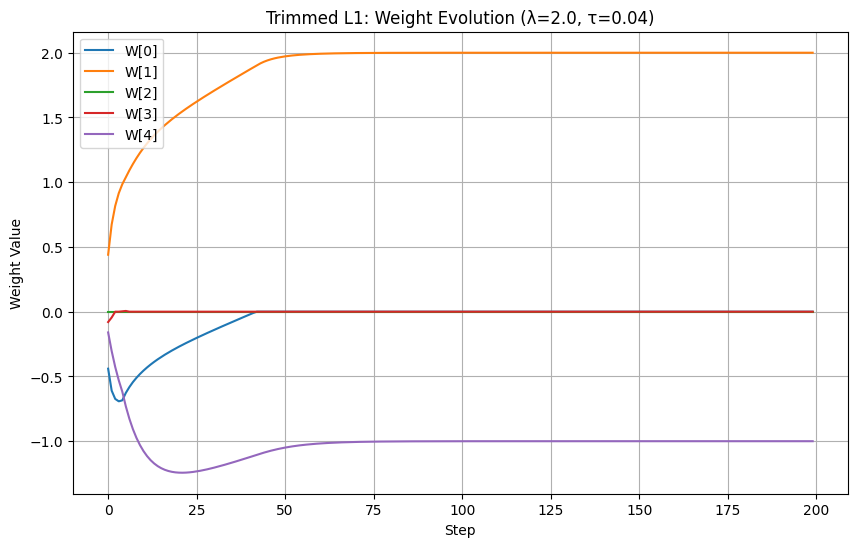

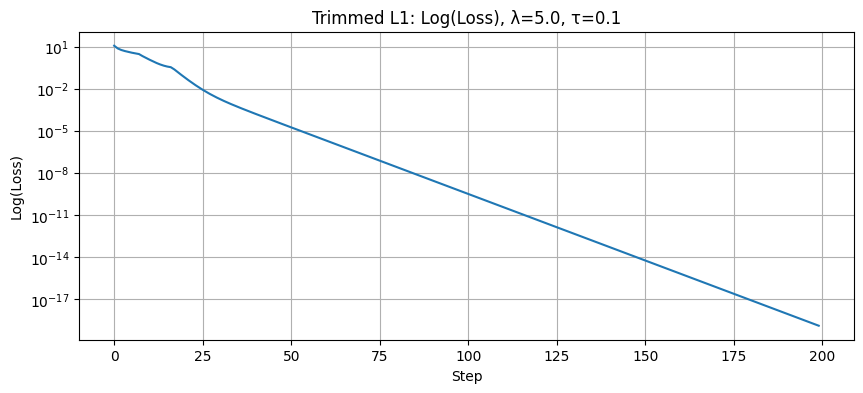

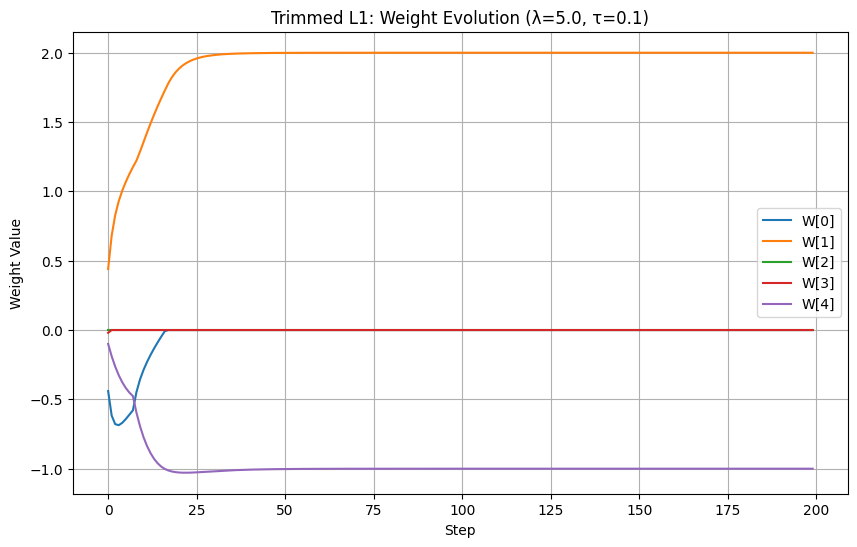

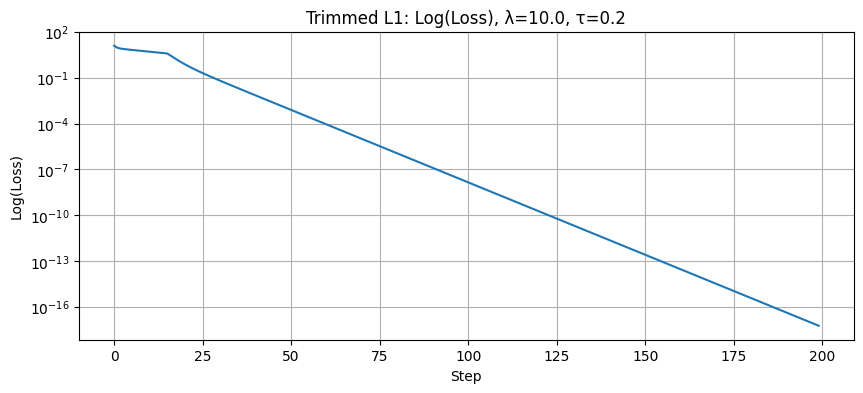

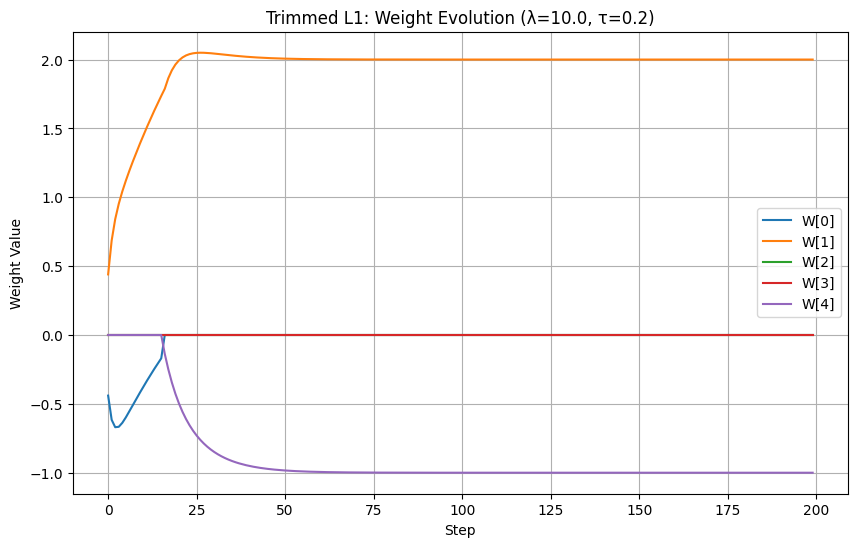

In [12]:
# Data
X = np.array([
    [-2, 2, 1, -1, -1],
    [-2, 1, -2, 0, 1],
    [ 1, 0, -2, 2, -1]
])
y = np.array([5, 1, 1]).reshape(-1, 1)
mu = 0.02
steps = 200

# lambda → threshold = mu * lambda
lambda_thresholds = [(1.0, 0.02), (2.0, 0.04), (5.0, 0.1), (10.0, 0.2)]

def trimmed_soft_threshold(W, tau, k_trim=3):
    flat_W = W.flatten()
    abs_sorted_idx = np.argsort(np.abs(flat_W))

    # Apply soft threshold only to the smallest k_trim weights
    W_new = flat_W.copy()
    for i in abs_sorted_idx[:k_trim]:
        w = flat_W[i]
        if np.abs(w) <= tau:
            W_new[i] = 0.0
        else:
            W_new[i] = np.sign(w) * (np.abs(w) - tau)
    return W_new.reshape(W.shape)

for lam, tau in lambda_thresholds:
    W = np.zeros((5, 1))
    loss_list = []
    W_history = []

    for step in range(steps):
        # Gradient step (no regularization)
        grad = 2 * X.T @ (X @ W - y)
        W_temp = W - mu * grad

        # Apply trimmed soft thresholding
        W = trimmed_soft_threshold(W_temp, tau)

        # Compute original loss (without reg term)
        loss = np.sum((X @ W - y) ** 2)
        loss_list.append(loss)
        W_history.append(W.flatten())

    W_history = np.array(W_history)

    # Plot log(L)
    plt.figure(figsize=(10, 4))
    plt.plot(loss_list)
    plt.yscale('log')
    plt.xlabel('Step')
    plt.ylabel('Log(Loss)')
    plt.title(f'Trimmed L1: Log(Loss), λ={lam}, τ={tau}')
    plt.grid(True)
    plt.show()

    # Plot W trajectories
    plt.figure(figsize=(10, 6))
    for i in range(5):
        plt.plot(W_history[:, i], label=f'W[{i}]')
    plt.xlabel('Step')
    plt.ylabel('Weight Value')
    plt.title(f'Trimmed L1: Weight Evolution (λ={lam}, τ={tau})')
    plt.legend()
    plt.grid(True)
    plt.show()

(1) Compared to standard L1 regularization, the Trimmed L1 (Tl1) method preserves large-magnitude weights by not penalizing the top-2 largest absolute values. This helps reduce the bias introduced by standard L1, allowing important features to remain strong. As a result, Tl1 may lead to better convergence behavior and potentially lower final loss, especially when the true solution is sparse but not overly penalized.

(2) Compared to iterative pruning, Tl1 shows similar early behavior by shrinking or zeroing out small-magnitude weights. However, it avoids hard thresholding of all but two weights, allowing more flexibility for important weights to emerge. In the first 20 steps, when λ was smaller (e.g., 1.0), fewer weights were pruned and the model retained more flexibility—resulting in slower pruning and higher loss. When λ was larger (e.g., 10.0), the stronger regularization caused faster sparsity (more weights zeroed out earlier) and more rapid loss reduction.